In [1]:
# coding: utf-8

import numpy as np
import torch
import os
import time

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline  

from networks import *
from network import CoordRegressionNetwork
from torch.utils.data import DataLoader
from dataset_factory import DatasetFactory, ROOT_DIR
import multiprocessing
from tqdm import tqdm

# gpu setting
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.backends.cudnn.enabled = True
device = torch.device("cuda" if True else "cpu")
num_threads = multiprocessing.cpu_count()
print("GPU NUM: %d, Thread NUM: %d"%(torch.cuda.device_count(),num_threads))

%load_ext autoreload
%autoreload 2

GPU NUM: 1, Thread NUM: 20


In [2]:
# load pretrain model
# modelpath = "./models/resnet18_224_new_best.t7"
# modelname = "shufflenetv2"
modelname = "resnet18"
modelpath = "./models/%s_224_adam_best.t7"%(modelname)
inputsize = 224
net = CoordRegressionNetwork(n_locations=16, backbone=modelname).to(device)

train_dataset = DatasetFactory.get_train_dataset("resnet", inputsize)
train_dataloader = DataLoader(train_dataset, batch_size=256,
                        shuffle=True, num_workers = num_threads)

test_dataset = DatasetFactory.get_test_dataset("resnet", inputsize)
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers = num_threads)

  0%|          | 0/8 [00:00<?, ?it/s]

average forward seconds=0.012341 s| fps=81


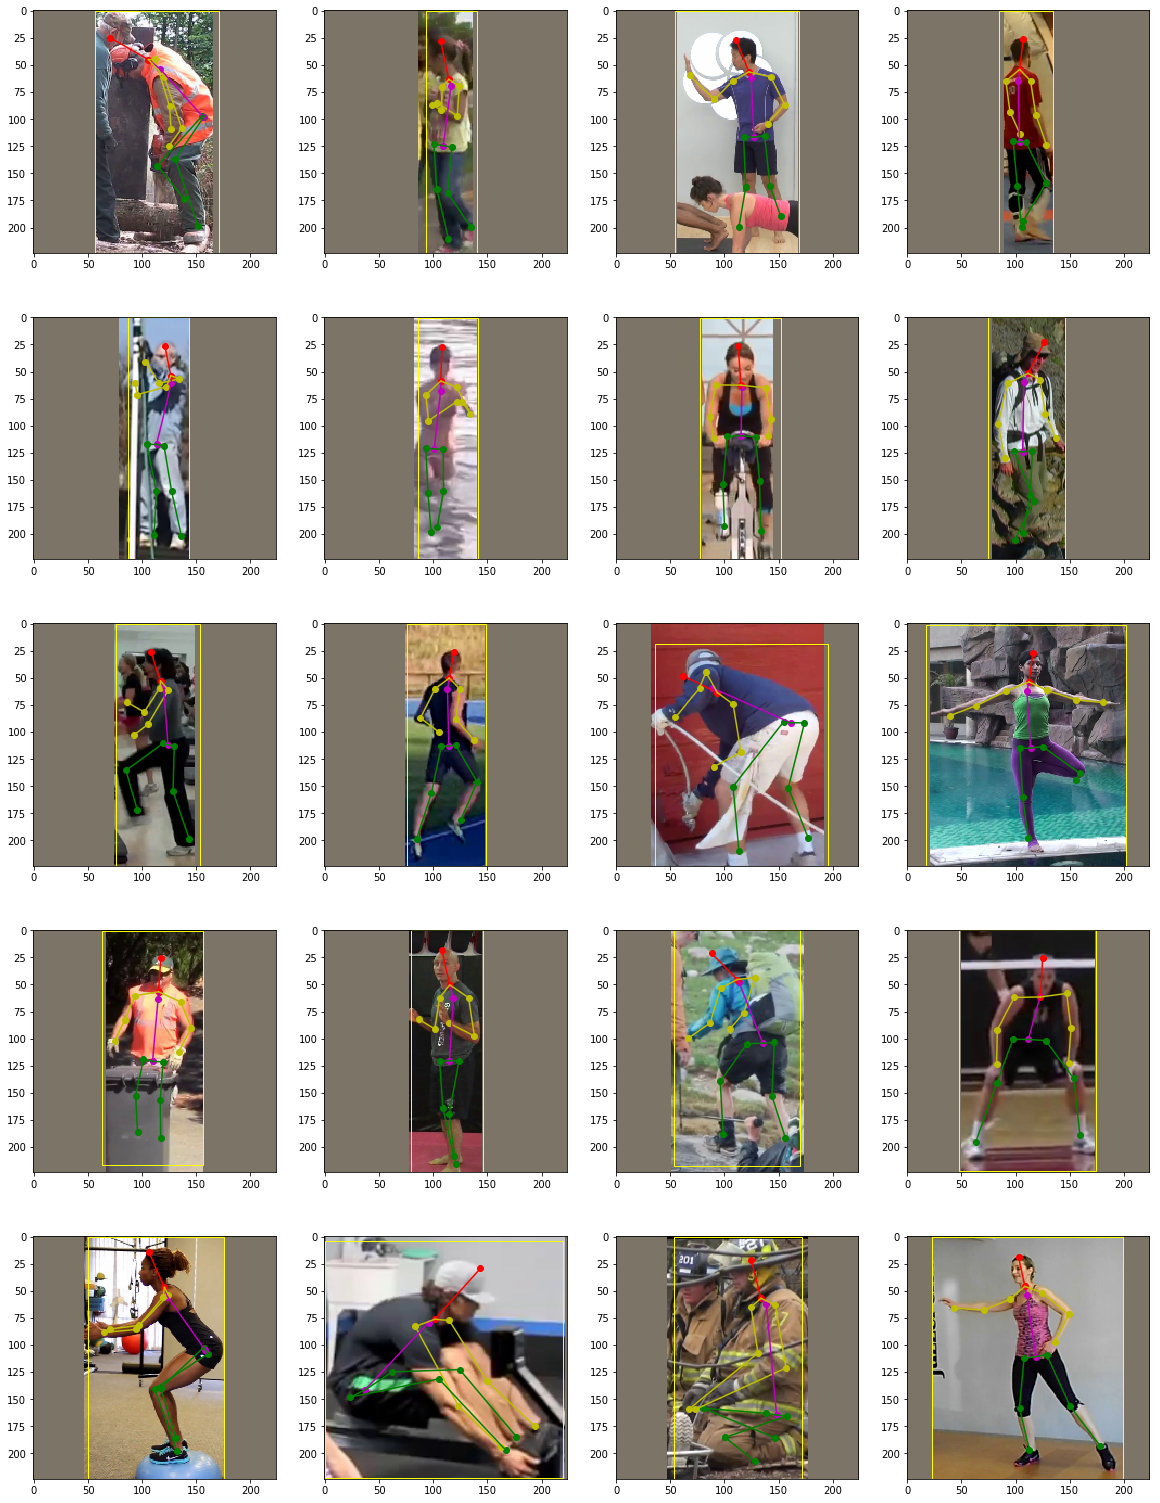

In [3]:
from dataloader import display_pose
plt.figure(figsize=(20,140))

with torch.no_grad():  
    net.load_state_dict(torch.load(modelpath))
    net = net.eval()

    for i_batch, sample_batched in enumerate(tqdm(test_dataloader)):

        images = sample_batched['image'].to(device)
        poses = sample_batched['pose'].to(device)
        
        t0 = time.clock()
        coords, heatmaps = net(images)
        t1 = time.clock()
        print('average forward seconds=%f s| fps=%d'%((t1-t0),int(1/((t1-t0)))))
        
        for ids in range(40,60):
            display_pose(images[ids][:3,:,:],coords[ids],ids)
        plt.show()
        break

In [ ]:
plt.imshow(heatmaps[0, 8].data.cpu().numpy())
plt.show()

In [ ]:
from torchsummary import summary
import torch
from networks import *
from networks.senet import se_resnet
from torchvision.models import resnet18
import os
device = torch.device("cuda" if True else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# model = se_resnet.senet18_ed().to(device)
model = resnet18_ed().to(device)
# model = resnet18().to(device)
# model = ShuffleNetV2.shufflenetv2_ed(width_mult=1.0).to(device)
# model = MobileNetV2.mobilenetv2_ed(width_mult=1.0).to(device)
# model = nn.Sequential(*(list(model.children())[:-3]))
# model = squeezenet1_1().to(device)
summary(model, input_size=(3, 224, 224))
# print(list(model.children())[:-1])

In [ ]:
from thop import profile
from torchsummary import summary
import torch
from networks import *
from torchvision.models import resnet18

import os
device = torch.device("cuda" if False else "cpu")

model = resnet.resnet18_ed().to(device)
# model = UNet().to(device)
# model = resnet18().to(device)
# model = ShuffleNetV2.shufflenetv2_ed(width_mult=1.0).to(device)
# model = MobileNetV2.mobilenetv2_ed(width_mult=1.0).to(device)
# model = squeezenet1_1().to(device)
flops, params = profile(model, input_size=(1, 3, 224,224))
print(params/(1024**2), flops/(1024**3))

In [30]:
import json
from tqdm import tqdm
j_path="/home/yuliang/code/AlphaPose-pytorch/train_sppe/data/coco/person_keypoints_val2017.json"
txt_path = "/home/yuliang/code/AlphaPose-pytorch/train_sppe/data/coco/list/trainval.txt"
with open(j_path, 'rb') as j:
    j_data = json.load(j)
    with open(txt_path, 'wb') as t:
        for img_anno in tqdm(j_data['annotations']):
            t.write(("%012d\n"%img_anno['image_id']).encode())


100%|██████████| 11004/11004 [00:00<00:00, 206496.90it/s]

In [35]:
j_data['annotations'][134]

{'area': 1812.626,
 'bbox': [385.79, 233.83, 28.04, 97.07],
 'category_id': 1,
 'id': 229636,
 'image_id': 577932,
 'iscrowd': 0,
 'keypoints': [402,
  243,
  2,
  403,
  241,
  2,
  399,
  240,
  2,
  0,
  0,
  0,
  395,
  242,
  2,
  406,
  253,
  2,
  392,
  255,
  2,
  414,
  262,
  1,
  392,
  271,
  2,
  409,
  255,
  2,
  394,
  282,
  2,
  407,
  283,
  2,
  398,
  284,
  2,
  403,
  306,
  2,
  397,
  305,
  2,
  401,
  323,
  2,
  395,
  322,
  2],
 'num_keypoints': 16,
 'segmentation': [[389.3,
   330.55,
   390.35,
   300.76,
   389.65,
   294.1,
   388.6,
   274.13,
   385.79,
   259.76,
   386.14,
   254.86,
   390.7,
   248.9,
   391.75,
   246.45,
   395.25,
   235.23,
   402.96,
   233.83,
   407.17,
   245.74,
   406.12,
   250.3,
   413.83,
   255.56,
   412.07,
   262.91,
   411.72,
   293.05,
   410.67,
   294.45,
   407.17,
   295.85,
   407.87,
   302.16,
   405.06,
   308.47,
   403.66,
   313.73,
   401.91,
   318.98,
   405.77,
   323.19,
   408.57,
   328.79,

In [ ]:
import numpy as np

def create_heatmap(self, size, poses, sigma):
        
    x = np.arange(0, size)
    y = np.arange(0, size)
    x, y = np.meshgrid(x, y)
    guass_heatmap = np.zeros([poses.shape[1], size, size])
    sigma /= size

    for pose in poses:
        for idx,(x0,y0) in enumerate(pose):
            guass_heatmap[idx] += np.exp(-((x*1.0/size-x0)**2+(y*1.0/size-y0)**2)/(2.0*sigma**2))

    return guass_heatmap

In [ ]:
heatmap = self.create_heatmap(image.shape[2], label[:,4:].reshape(-1,17,3)[:,:,:2], 1.0)

In [ ]:
import json
from tqdm import tqdm
j_path="/home/yuliang/code/AlphaPose-pytorch/train_sppe/data/coco/person_keypoints_val2017.json"

with open(j_path, 'rb') as j:
    j_data = json.load(j)
    for img_anno in tqdm(j_data['annotations']):
        
        binary_path = "/home/yuliang/code/Deeplab-Seg/Deeplab/datasets/coco/PoseHeatmap/binary"
        guass_path = "/home/yuliang/code/Deeplab-Seg/Deeplab/datasets/coco/PoseHeatmap/guass"
        
        t.write(("%012d\n"%img_anno['image_id']).encode())

In [36]:
import pycocotools